In [1]:
# !pip3 install fasttext --quiet
# !pip install langdetect --quiet

In [46]:
import os, sys, numpy as np, pandas as pd, matplotlib.pyplot as plt
import torch
from torch import nn
import fasttext, fasttext.util
from sklearn.model_selection import train_test_split
from torchsummary import summary
from tqdm.auto import tqdm
# from langdetect import detect

os.chdir('/Users/siva/Downloads')
ft = fasttext.load_model('wiki/wiki.hi.bin')

In [ ]:
#Preprocess Text

# hasoc=pd.read_csv('/content/hindi_dataset.tsv',sep='\t')
# hasoc=hasoc[['text','task_1']]
# hasoc['preprocessed_text']=list(range(len(hasoc)))
# hasoc.head()

# for idx in range(2000,len(hasoc)):
#   sent=hasoc.iloc[idx].text.split()
#   new=[]
#   for word in sent:
#     try:
#       if '#' in word or word.isnumeric() or detect(word)=='en':
#         continue
#       elif detect(word)=='hi' or detect(word)=='ne' or detect(word)=='mr':
#         new.append(word)
#     except:
#       continue
#   if len(new)>0:
#     preprocessed_sent=' '.join(new)
#     hasoc['preprocessed_text'][idx]=preprocessed_sent

#   if idx%100==0:
#     print(idx)

# hasoc.to_csv('/content/hindi2.csv')

In [273]:
hasoc=pd.read_csv('hindi.csv')
hasoc=hasoc
hasoc=hasoc.join(pd.get_dummies(hasoc['task_1'])) # one hot encoding
train,val=train_test_split(hasoc,train_size=0.8,test_size=0.2,random_state=42) # train test split
train.head()

,Unnamed: 0,text,preprocessed_text,task_1,HOF,NOT
2509,2509,ये साला धर्म है या फिर रंडी भड़वों का कोठा।,ये साला धर्म है या फिर रंडी भड़वों का कोठा।,HOF,1,0
332,332,"एक जवान जो अपना घर, बीवी, बच्चे छोड़ के सीमापर...","एक जवान जो अपना घर, बीवी, बच्चे छोड़ के सीमापर...",NOT,0,1
1113,1113,LIVE: PM Shri @narendramodi addresses the Indi...,1113,NOT,0,1
751,751,"रंडी अंजनवा ओम मोदी नॉट कश्यप ,भड़वे सारदाना, ...","रंडी अंजनवा ओम मोदी नॉट कश्यप ,भड़वे सारदाना, ...",HOF,1,0
720,720,ये इतनी बडी रंडी है की इसको कितना भी गाली दो इ...,ये इतनी बडी रंडी है की इसको कितना भी गाली दो इ...,HOF,1,0


In [308]:
class SentimentAnalyser(nn.Module):
    def __init__(self):
        super().__init__()
        self.model=nn.Sequential(
            nn.Linear(300,200),
            nn.Linear(200,100),
            nn.Linear(100,1),
        )
        self.loss=nn.BCEWithLogitsLoss()
    def forward(self,inp,target=None):
        pred=self.model(inp)
        if target!=None:
            loss=self.loss(pred,target)
            return loss,pred 
        return pred 

In [306]:

data=train.iloc[10]
sent=data.preprocessed_text.split()
target=data.HOF
l=len(sent)

#sentence embedding
sentence_embedding=np.zeros((300))
for word in sent:
    sentence_embedding+=ft.get_word_vector(word)
sentence_embedding/=l

sentence_embedding,target=torch.Tensor(sentence_embedding),torch.Tensor([target])

In [323]:
sent

["'चुप", 'कर', "भोसडीके!'"]

In [325]:
ft.get_word_vector(sent[2])

array([-1.35438010e-01,  1.01094842e-01, -4.78702150e-02, -1.28502240e-02,
        1.06755190e-01,  1.12354048e-01,  2.83279363e-02, -8.70371517e-03,
        1.27050150e-02,  1.20904490e-01,  9.63831171e-02, -4.45969665e-04,
       -5.90573857e-03, -5.45125268e-02, -3.38202007e-02, -7.31792679e-05,
        2.54890211e-02, -8.79362877e-03,  6.28464073e-02,  7.66239464e-02,
       -2.27214247e-02,  5.14726192e-02, -3.92290391e-02,  1.65187970e-01,
        1.81329057e-01,  4.21750732e-02, -3.43067124e-02,  9.39545408e-02,
        1.32944092e-01,  7.66980797e-02,  2.48610601e-02,  8.15354735e-02,
       -4.76057641e-02, -1.03275694e-01,  1.05440527e-01, -8.73629078e-02,
        6.00927994e-02,  2.03555394e-02,  1.40817650e-02,  9.80171189e-02,
       -4.34395894e-02,  7.38455215e-03,  2.34328844e-02,  2.38059070e-02,
        2.59352233e-02, -6.71883970e-02,  6.68056011e-02, -5.85667193e-02,
        9.15570706e-02, -5.95624596e-02,  1.11877866e-01,  4.49507385e-02,
        2.63480539e-03, -

In [313]:
def trainarc(model,df,opt):

    for idx in range(len(df)):
        data=df.iloc[idx]
        if data.preprocessed_text.isnumeric():
            continue
        sent=data.preprocessed_text.split()
        target=data.HOF
        l=len(sent)

        #sentence embedding
        sentence_embedding=np.zeros((300))
        for word in sent:
            sentence_embedding+=ft.get_word_vector(word)
        sentence_embedding/=l

        sentence_embedding,target=torch.Tensor(sentence_embedding),torch.Tensor([target])

        l,_=model(sentence_embedding,target)
        opt.zero_grad()
        l.backward()
        opt.step()

    return l

In [317]:
model=SentimentAnalyser()
summary(model,input_size=(300))

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Linear: 2-1                       60,200
|    └─Linear: 2-2                       20,100
|    └─Linear: 2-3                       1,010
|    └─Linear: 2-4                       11
├─BCEWithLogitsLoss: 1-2                 --
Total params: 81,321
Trainable params: 81,321
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Linear: 2-1                       60,200
|    └─Linear: 2-2                       20,100
|    └─Linear: 2-3                       1,010
|    └─Linear: 2-4                       11
├─BCEWithLogitsLoss: 1-2                 --
Total params: 81,321
Trainable params: 81,321
Non-trainable params: 0

In [314]:
opt=torch.optim.Adam(model.parameters(),lr=0.001)
epochs=5
trainloss_oe=[]

for epoch in tqdm(range(epochs)):
    loss=trainarc(model,train,opt)
    trainloss_oe.append(float(loss))
    print(loss)  

print(trainloss_oe)  

  0%|          | 0/5 [00:00<?, ?it/s]

tensor(0.2396, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1572, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1305, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1238, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1121, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
[0.23962344229221344, 0.15720267593860626, 0.13050588965415955, 0.12382008135318756, 0.1120721623301506]


In [315]:
output={'target':[],'pred':[]}

for idx in range(len(val)):
    test_data=val.iloc[idx]
    if test_data.preprocessed_text.isnumeric():
        continue
    s=test_data.preprocessed_text.split()
    l=len(s)
    t=test_data.HOF

    #sentence embedding
    sentence_embedding=np.zeros((300))
    for word in s:
        sentence_embedding+=ft.get_word_vector(word)
    sentence_embedding/=l

    sentence_embedding,target=torch.Tensor(sentence_embedding),torch.Tensor([t])
    l,p=model(sentence_embedding,target)
    output['target'].append(t)
    output['pred'].append(float(p))

In [316]:
from sklearn.metrics import confusion_matrix

def calculate_metrics(true_values, predicted_values):
    
    cm=confusion_matrix(true_values, predicted_values)
    tn, fp, fn, tp = cm.ravel()

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    return cm, accuracy, precision, recall


true_values = output['target']
predicted_values = list(map(lambda x: 0 if x < 0 else 1, output['pred']))

cm, accuracy, precision, recall = calculate_metrics(true_values, predicted_values)
print('Confusion matrix', cm)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Confusion matrix [[309  94]
 [100 374]]
Accuracy: 0.7787913340935005
Precision: 0.7991452991452992
Recall: 0.7890295358649789


<AxesSubplot:>

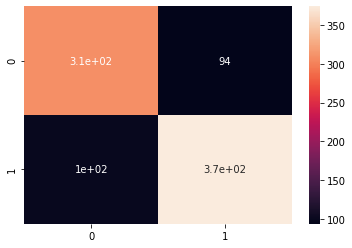

In [319]:
import seaborn as sns
sns.heatmap(cm,annot=True)

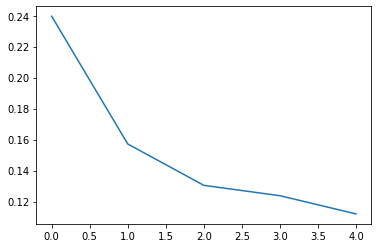

In [321]:
plt.plot(trainloss_oe)

In [ ]:
[0.0, 0.0, 0.0, 119.69122314453125, 47.00691223144531]
[2.3695321083068848, 5.3309149742126465, 18.231409072875977, 62.57204818725586, 0.0, 0.0, 0.0, 56.467281341552734, 0.0, 0.0]
[0.09590184688568115, 0.06789319217205048, 0.06132493540644646]

[0.23962344229221344, 0.15720267593860626, 0.13050588965415955, 0.12382008135318756, 0.1120721623301506]